In [2]:
import os, sys
sys.path.append(os.path.abspath('../utils'))

import pandas as pd
import numpy as np
import random
import math
import scipy
from scipy import stats

from sklearn.preprocessing import StandardScaler  # for feature scaling
from sklearn.model_selection import train_test_split  # for train/test split
import matplotlib.pyplot as plt  #For representation
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LogisticRegression
from sklearn.svm import l1_min_c  # for L1 regluarization path

# Example code for calculating accuracy, precision, recall, and F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
#from statkit.decision import net_benefit
from statkit.decision import net_benefit
from scipy import integrate


import dca_fs_tools as dcat
import dca_fs as dcafs

import torch
import copy

import pickle

# Demonstration of the mean-net-benefit loss function


Here we apply logistic regression to synthetic data and compare:

- log-loss
- Mean-net-benefit loss

$$c = \sqrt{a^2 + b^2}$$


## Logistic regression benchmark

In order to compare to standard logistic regression we employ sklearn's LR:

In [3]:
logreg = LogisticRegression(C=10**18)

We generate sythetic data with the following properties:

In [4]:
n_sample = 100000
true_params = [1.7, 0.8, -0.4]

df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
    dcat.make_synth_data(n_features = 3, n_sample = n_sample, true_coefs = true_params, true_bias=0.0, heteros=0.)

Fit the baseline sklearn LR:

In [5]:
logreg.fit(df_train[ind_var_names], df_train["y"])

LogisticRegression(C=1000000000000000000)

Fit the torch 

In [6]:
my_log_loss_model = dcafs.lr_train(df_train, n_epochs=10000, learn_rate=  1.0, loss_fun = 'log')
my_mnb_loss_model = dcafs.lr_train(df_train, n_epochs=10000, learn_rate=  1.0, loss_fun = 'mnb')

Make predictions from the three models on the test set.

In [7]:
sklearn_pred = logreg.predict_proba(df_test.drop("y", axis = 1))
my_log_loss_pred = dcat.make_net_prediction(my_log_loss_model["net"], df_test)
my_mnb_loss_pred = dcat.make_net_prediction(my_mnb_loss_model["net"], df_test)

combined_predictions = pd.concat([
    pd.DataFrame(sklearn_pred[:,1], columns = ["sklearn"]),
    pd.DataFrame(my_log_loss_pred, columns = ["log"]),
    pd.DataFrame(my_mnb_loss_pred, columns = ["mnb"])],
    axis = 1
)

combined_predictions["delta_skl_log"] = combined_predictions["sklearn"]-combined_predictions["log"]
combined_predictions["delta_skl_mnb"] = combined_predictions["sklearn"]-combined_predictions["mnb"]


Compare predictions

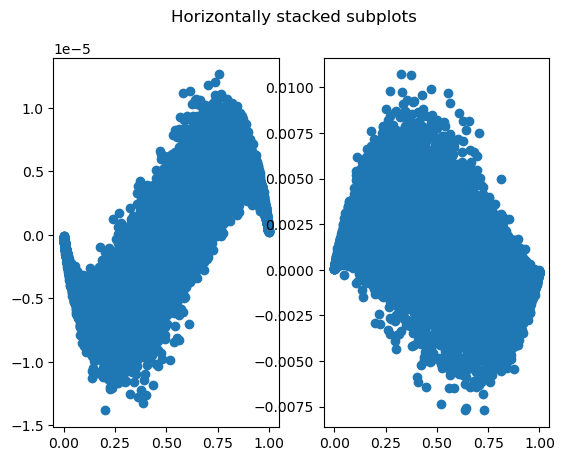

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
fig.suptitle('Horizontally stacked subplots')
ax1.scatter(combined_predictions["sklearn"], combined_predictions["delta_skl_log"])
ax2.scatter(combined_predictions["sklearn"], combined_predictions["delta_skl_mnb"])
fig.show()

Compare parameters

In [9]:

sklearn_params = logreg.coef_[0]
my_log_loss_params = my_log_loss_model['net'].linear.weight.detach().numpy()[0]
my_mnb_loss_params = my_mnb_loss_model['net'].linear.weight.detach().numpy()[0]

combined_params = pd.concat([
    pd.DataFrame(true_params, columns = ["True"]),
    pd.DataFrame(sklearn_params.transpose(), columns = ["sklearn"]),
    pd.DataFrame(my_log_loss_params.transpose(), columns = ["log"]),
    pd.DataFrame(my_mnb_loss_params.transpose(), columns = ["mnb"])
],
axis = 1)

combined_params

,True,sklearn,log,mnb
0,1.7,1.704978,1.704932,1.718711
1,0.8,0.798774,0.798744,0.806381
2,-0.4,-0.391720,-0.391717,-0.405354


Make bootstrap distributions

In [12]:
# Set this variabe to decide whether to load the previously run picked version or recalculate
load_pickled_version = True

if load_pickled_version:
    with open('../data/tmp0.pkl', 'rb') as f:
        [skl_boot, torch_boot_log, torch_boot_mnb] = pickle.load(f)
else:
    n_bootstraps = 300

    skl_boot = []
    torch_boot_log = []
    torch_boot_mnb = []

    for i in range(3):
        for boot in range(n_bootstraps):
            #Make a bootstrap sample
            #-------------------------#
            df_boot = df_train.sample(frac=1, replace=True)

            #scikit learn
            #-------------
            skl_boot.append(dcat.lr_skl_boot(logreg, df_boot, df_test, label = i))

            # torch - log-loss
            #-------
            torch_boot_log.append(dcat.lr_boot(df_boot, df_test, loss_fun="log", label = i))

            # torch - mnb-loss
            #-------
            torch_boot_mnb.append(dcat.lr_boot(df_boot, df_test, loss_fun="mnb", label = i))

    skl_boot = pd.concat(skl_boot, axis = 0).reset_index().drop("index", axis=1)
    torch_boot_log = pd.concat(torch_boot_log, axis = 0).reset_index().drop("index", axis=1)
    torch_boot_mnb = pd.concat(torch_boot_mnb, axis = 0).reset_index().drop("index", axis=1)


    with open('tmp0.pkl', 'wb') as f:
        pickle.dump([skl_boot, torch_boot_log, torch_boot_mnb], f)

In [10]:
skl_boot

,label,auc,mnb,x0,x1,x2
0,0,0.857632,0.269603,1.687911,0.776173,-0.405143
1,0,0.857684,0.269677,1.690369,0.780443,-0.420163
2,0,0.857769,0.269691,1.675960,0.797241,-0.416232
3,0,0.857686,0.269690,1.694398,0.785107,-0.416760
4,0,0.857729,0.269597,1.659390,0.774798,-0.422619
...,...,...,...,...,...,...
895,2,0.857683,0.269627,1.676021,0.777247,-0.408896
896,2,0.857645,0.269563,1.688461,0.779919,-0.403901
897,2,0.857657,0.269722,1.703990,0.780694,-0.428097
898,2,0.857633,0.269694,1.711189,0.780254,-0.424195


Plot the bootstrap distributions

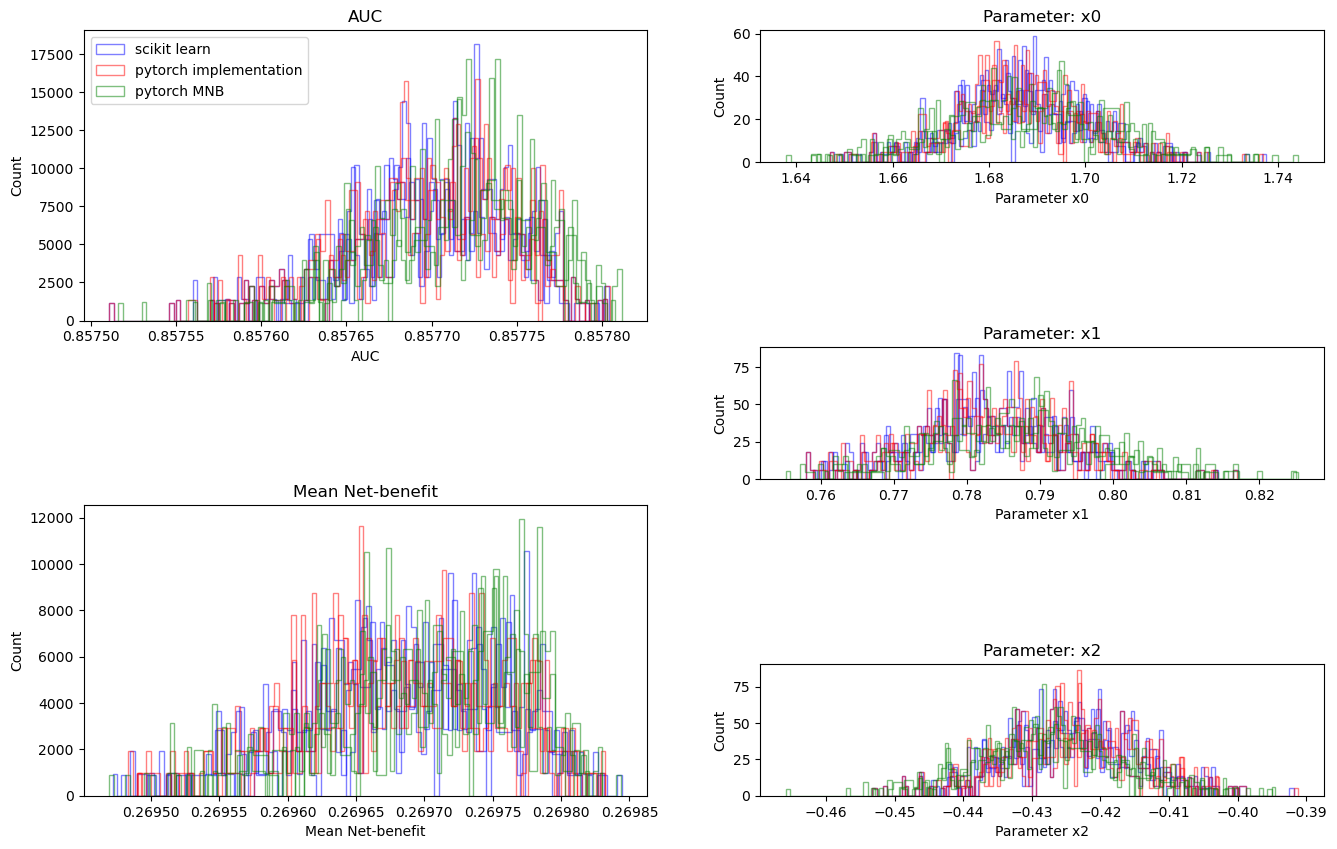

In [11]:
dcat.plot_bootstrap(skl_boot, torch_boot_log, torch_boot_mnb)

We see that...

## Difference between log-loss and Mean Net-benefit loss

In order to compare to standard logistic regression we employ sklearn's LR:

In [11]:
logreg = LogisticRegression(C=10**18)

We generate sythetic data with the following properties:

In [12]:
n_sample = 100000
true_params = [1.7, 0.8, -0.4]

df_train_het, df_test_het, df_noisy_train_het, df_noisy_test_het, ind_var_names_het, n_features_het, true_coefs_het = \
    dcat.make_synth_data(n_features = 3, n_sample = n_sample, true_coefs = [1.7, 0.8, -0.4], true_bias=0.0, heteros=2.5) 

Fit the baseline sklearn LR:

In [13]:
logreg.fit(df_train_het[ind_var_names], df_train_het["y"])

LogisticRegression(C=1000000000000000000)

Fit the torch 

In [14]:
my_log_loss_het_model = dcafs.lr_train(df_train_het, n_epochs=1000, learn_rate=  1.0, loss_fun = 'log')
my_mnb_loss_het_model = dcafs.lr_train(df_train_het, n_epochs=1000, learn_rate=  1.0, loss_fun = 'mnb')

Make predictions from the three models on the test set.

In [15]:
sklearn_het_pred = logreg.predict_proba(df_test_het.drop("y", axis = 1))
my_log_loss_het_pred = dcat.make_net_prediction(my_log_loss_het_model["net"], df_test_het)
my_mnb_loss_het_pred = dcat.make_net_prediction(my_mnb_loss_het_model["net"], df_test_het)

combined_het_predictions = pd.concat([
    pd.DataFrame(sklearn_het_pred[:,1], columns = ["sklearn"]),
    pd.DataFrame(my_log_loss_het_pred, columns = ["log"]),
    pd.DataFrame(my_mnb_loss_het_pred, columns = ["mnb"])],
    axis = 1
)

combined_het_predictions["delta_skl_log"] = combined_het_predictions["sklearn"]-combined_het_predictions["log"]
combined_het_predictions["delta_skl_mnb"] = combined_het_predictions["sklearn"]-combined_het_predictions["mnb"]


Compare predictions

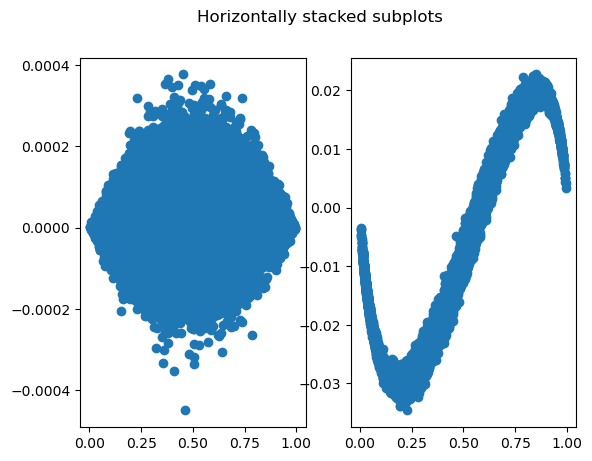

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
fig.suptitle('Horizontally stacked subplots')
ax1.scatter(combined_het_predictions["sklearn"], combined_het_predictions["delta_skl_log"])
ax2.scatter(combined_het_predictions["sklearn"], combined_het_predictions["delta_skl_mnb"])
fig.show()

Compare parameters

In [17]:

sklearn_het_params = logreg.coef_[0]
my_log_loss_het_params = my_log_loss_het_model['net'].linear.weight.detach().numpy()[0]
my_mnb_loss_het_params = my_mnb_loss_het_model['net'].linear.weight.detach().numpy()[0]

combined_het_params = pd.concat([
    pd.DataFrame(true_params, columns = ["True"]),
    pd.DataFrame(sklearn_het_params.transpose(), columns = ["sklearn"]),
    pd.DataFrame(my_log_loss_het_params.transpose(), columns = ["log"]),
    pd.DataFrame(my_mnb_loss_het_params.transpose(), columns = ["mnb"])
],
axis = 1)

combined_params

,True,sklearn,log,mnb
0,1.7,1.688262,1.688235,1.689369
1,0.8,0.783456,0.783443,0.787092
2,-0.4,-0.423830,-0.423822,-0.426895


Make bootstrap distributions

In [18]:
# Set this variabe to decide whether to load the previously run picked version or recalculate
load_pickled_version = True

if load_pickled_version:
    with open('tmp.pkl', 'rb') as f:
        [skl_het_boot, torch_het_boot_log, torch_het_boot_mnb] = pickle.load(f)
else:
    n_bootstraps = 300

    skl_het_boot = []
    torch_het_boot_log = []
    torch_het_boot_mnb = []
    for i in range(3):
        for boot in range(n_bootstraps):
            #Make a bootstrap sample
            #-------------------------#
            df_boot_het = df_train_het.sample(frac=1, replace=True)

            #scikit learn
            #-------------
            skl_het_boot.append(dcat.lr_skl_boot(logreg, df_boot_het, df_test_het, label = i))

            # torch - log-loss
            #-------
            torch_het_boot_log.append(dcat.lr_boot(df_boot_het, df_test_het, loss_fun="log", label = i))

            # torch - mnb-loss
            #-------
            torch_het_boot_mnb.append(dcat.lr_boot(df_boot_het, df_test_het, loss_fun="mnb", label = i))

    skl_het_boot = pd.concat(skl_het_boot, axis = 0).reset_index().drop("index", axis=1)
    torch_het_boot_log = pd.concat(torch_het_boot_log, axis = 0).reset_index().drop("index", axis=1)
    torch_het_boot_mnb = pd.concat(torch_het_boot_mnb, axis = 0).reset_index().drop("index", axis=1)

    #with open('tmp.pkl', 'wb') as f:
    #    pickle.dump([skl_het_boot, torch_het_boot_log, torch_het_boot_mnb], f)


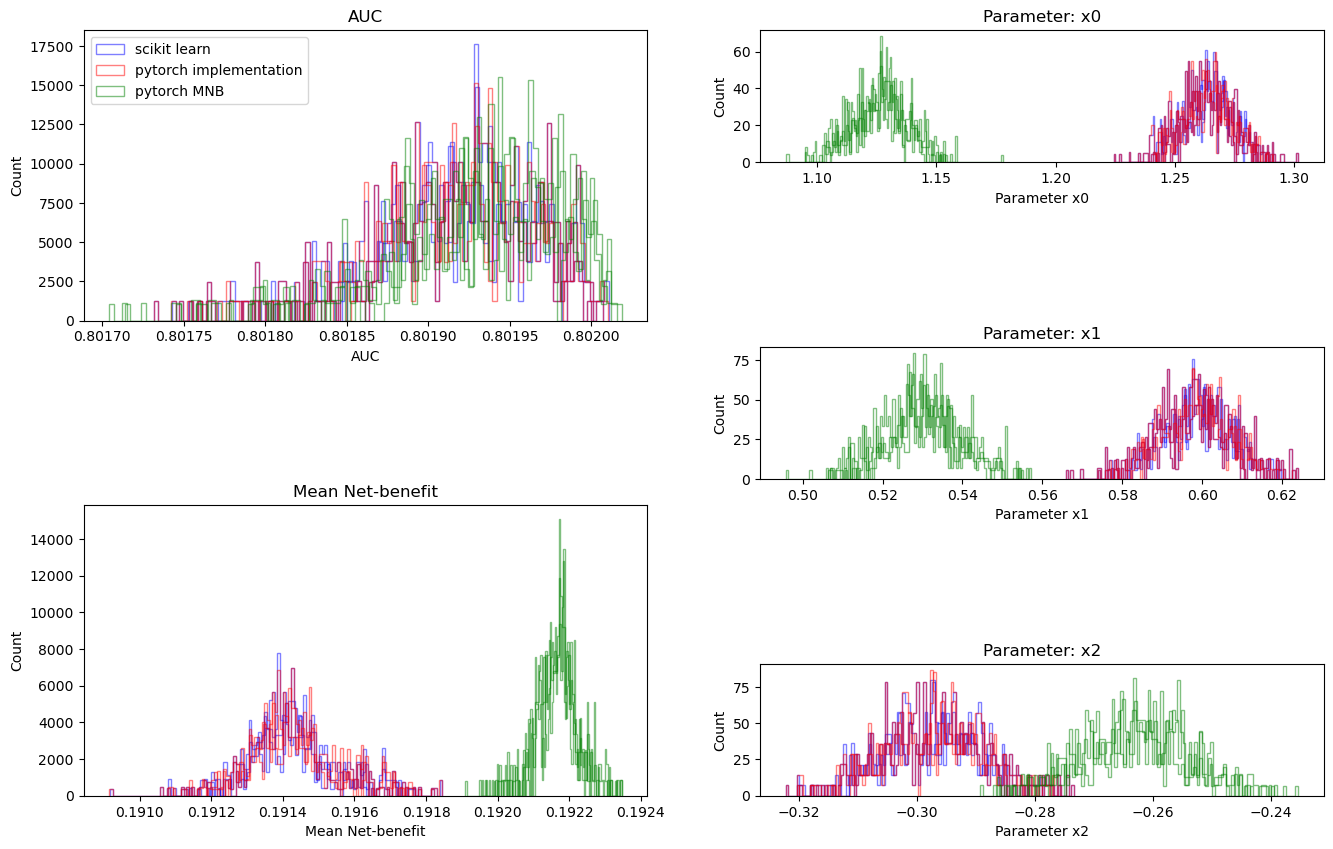

In [19]:
dcat.plot_bootstrap(skl_het_boot, torch_het_boot_log, torch_het_boot_mnb)

Plot the bootstrap distributions

We see that...